# Data Anaysis Project part1:


I am currently enrolled in a Google Data Analytics Professional Certificate course and plan to apply the skills and knowledge I am learning to my own data analysis project. This will allow me to solidify my understanding of the concepts and techniques taught in the course. 

#### Process to follow:
* Ask
* Prepare
* Process
* Analyze
* Share
* Act



## Overview of the project:

I am conducting an analysis of the rental housing market in Vancouver to identify popular rental properties in the area. Based on the results, I hope to find a valuable investment property and assess its value. I have chosen to focus on the Vancouver market because it is the one of the most wanted place in Canada, it offers a wide variety of properties, and large pool of potential investments to analyze. 


# ASK 

## Primery question to answer from this analysis:

### "What is the appropriate price to pay for your investment property in current economic condition? And why?"
    
    It's widely believed that Canadian real estate is overpriced, but what is the actual value of a property? To answer this question, I will evaluate property values based on current market conditions and determin the apporopriate price to pay for an investment property. This calculation involves several factors, but I will focus particularly on the revenue generation potential of the property, as this is a crucial aspect of any investment. By analyzing the revenue potential of a property, I aim to gain insight into its true value. 

#### Data source:

    Craigslist advertizement. Data started to collect since December 15, 2022. 

#### Questions to ask.
* Rental price by propety types.
* Rental price by area. 
* Number of advatizing by type of the property.
* Rental price trend.
* Correlation between housing price and rental price. And which way they are trending. 
* What is the short termand long term prediction.  


## Prepare  

### Collect the Data



In [1]:
# Import libralis
from requests import get
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import numpy as np

from time import sleep
import re
from random import randint
from warnings import warn
from time import time
from IPython.display import clear_output

In [2]:
class Url:
    def __init__(self, city_name, sub_city=None, num_post=0):
        self.city_name = city_name
        self.sub_city = sub_city
        self.num_post = num_post
        self.url = self.get_url()
        
    def get_url(self):
        if self.city_name == 'Abbotsford':
            url = f'https://{self.city_name.lower()}.craigslist.org/search/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        else:
            url = f'https://{self.city_name.lower()}.craigslist.org/search/{self.sub_city}/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        return url 

In [3]:
# Vanvouver rental housing
url = Url("Vancouver", 'van')
url_ = url.url

response = get(url_)


soup = BeautifulSoup(response.text, 'html.parser')

posts = soup.find_all('li', class_='result-row')
print(type(posts)) # to double check that I got resultSet
print(len(posts)) # to double check I got 120 elements

<class 'bs4.element.ResultSet'>
121


In [4]:
%%time
# Find the total number of posts to find the limit of the pagination
city = 'Vancouver'
sub_city = 'van'
response = get(url_)
soup = BeautifulSoup(response.text, 'html.parser')
posts = soup.find_all('li', class_='result-row')
results_num = soup.find('div', class_='search-legend')
results_total = int(results_num.find('span', class_='totalcount').text)
print(f"Total number of search result: {results_total}")

# each page has 119 posts so each new page is defined as follows; s=120, s=240, .....
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_date = []
post_cities = []
num_bedroom = []
sqfts = []
prices = []
post_titles = []
post_links = []

for page in pages:
    
    # get request
    url = Url(city_name=city, sub_city=sub_city, num_post=page)
    url_ = url.url
    response = get(url_)
    
    sleep(1)
    
    # throw warning for status code that are not 200
    if response.status_code != 200:
        warn(f'Request: {requests}; Status code: {response.status_code}')
        
    soup = BeautifulSoup(response.text, 'html.parser')
    
    posts = soup.find_all('li', class_='result-row')
    
    
    # Extract data 
    for post in posts:
        
        if post.find('span', class_ = 'result-hood') is not None:
            
            # Posting date
            post_datetime = post.find('time', class_='result-date')['datetime']
            post_date.append(post_datetime)
            
            # Neighbourhoods
            post_city = post.find('span', class_='result-hood').text.strip('( )')
            post_cities.append(post_city)
            
            # title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_titles.append(post_title_text)
            
            # Post price in integer
            price = int(post.find('span', class_='result-price').text.split('$')[1].replace(',', ''))
            prices.append(price)
            
            # Post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                num_bedroom.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    num_bedroom.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
        iterations += 1
        #print("Page" + str(iterations) + "Scraped Successfully!")   

Total number of search result: 3000
CPU times: total: 4.33 s
Wall time: 49.2 s


In [5]:
# create DataFrame
df = pd.DataFrame({'Post Datetime': post_date,
                   'City Code': city.upper()[:3],
                   'Area Code': sub_city.upper(),
                   'Post Title': post_titles,
                   'Post URL': post_links,
                  'Neighborhood': post_cities,
                  'Bedroom': num_bedroom,
                  'SQFT': sqfts,
                  'Price': prices})

print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Post Datetime  3066 non-null   object 
 1   City Code      3066 non-null   object 
 2   Area Code      3066 non-null   object 
 3   Post Title     3066 non-null   object 
 4   Post URL       3066 non-null   object 
 5   Neighborhood   3066 non-null   object 
 6   Bedroom        2814 non-null   object 
 7   SQFT           2761 non-null   float64
 8   Price          3066 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 215.7+ KB
None


,Post Datetime,City Code,Area Code,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,2022-12-26 17:57,VAN,VAN,Available February 1st -NEW BUILDING-Pet Frien...,https://vancouver.craigslist.org/van/apa/d/van...,Downtown Vancouver,2,705.0,3700
1,2022-12-26 17:56,VAN,VAN,Pet Friendly studio with storage and patio in ...,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,NaN,417.0,2355
2,2022-12-26 17:56,VAN,VAN,One Bedroom in Kitsilano,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,1,600.0,1875
3,2022-12-26 17:56,VAN,VAN,NEW BUILDING-Pet Friendly 2 BR@ 1168 Pendrell-...,https://vancouver.craigslist.org/van/apa/d/van...,Downtown Vancouver,2,705.0,3700
4,2022-12-26 17:53,VAN,VAN,NEW BUILDING-Available February 1st-Pet Friend...,https://vancouver.craigslist.org/van/apa/d/van...,Downtown Vancouver,2,705.0,3700



## Process

* Clean data
    * Remove duplecates.
    * If the number of bed room is NaN, assume it is bachelor suite (number of bedroom as 0)
    * Convert Post Datetime object to Datetime, then seperate Date and Time. 
    * Sort the dataFrame by Post Datetime. 
    * Convert number of bedroom string to integer. 
* Add parameters to analyze data
    * Specific neighbourhood and clean up messy neighbourhoode. 
    * Post area code connecting the city name and area name to distinguish different area in future with other data. 
    * Calcualte Price/SQFT
    * Find out if the suite is furnished or not by finding the key word "Furnished" in the post title. 
    * Seperate the data by SQFT/Price price range. gategory 1 to 4, which 1 is cheap and 4 is expensive. 

### I am trying to identify the area if the address is provided. 

In [6]:
# Get all the Nighborhood start with number, I assume those are address. Then identify the area using google geocoding API.
address = []
for string in df["Neighborhood"].unique():
    if string[0].isdigit():
        address.append(string)
address

['1022 Nelson Street, Vancouver, BC',
 '282 West 44th Avenue, Vancouver',
 '1026 West 13th Avenue, Vancouver',
 '3487 Binning Road',
 '389 West 59th',
 '1283 Howe St Vancouver',
 '938 Smithe Street Downtown Vancouver',
 '1239 West Georgia',
 '1450 Pennyfarthing Dr, Vancouver',
 '2615 Columbia Street, Vancouver, BC',
 '5639 Remington Crescent',
 '175 2nd Street West',
 '1342 Camridge Road',
 '42nd & Dunbar',
 '905 E 41st AVE, Vancouver V5W 1P8',
 '747 E 3rd St North Vancouver, BC V7L 1G8',
 '777 Richards St and Robson St',
 '3208 ASH STREET, VANCOUVER',
 '7322 GRANVILLE STREET, VANCOUVER',
 '1088 Richards Street',
 '33 Smithe Street, Vancouver',
 '3188 Riverwalk Avenue, Vancouver',
 '5058 Joyce Street, Vancouver',
 '1283 Howe Street, Vancouver',
 '1723 Alberni Street',
 '1068 hornby st',
 '8625 Osler st, Vancouver',
 '695 west 17th',
 '7638 Cambie Street',
 '26xx W. King Edward Ave.',
 '19xx Quilchena Crescent',
 '1708 Ontario Street, Vancouver BC',
 '8290 Montcalm St.',
 '777 Richards.

If Neighborhood starts with number, then check the area name with google geocoding API. 

if Neighborhood is area name, then use as area name.

clean up all the Neighborhood - cut , / and show same thing but differently. Also, make all lower case. 

In [7]:
# Convert Datetime then split seperate columns
df['Post Datetime'] = pd.to_datetime(df["Post Datetime"])
df['Post Date'] = df['Post Datetime'].dt.date
df['Post Time'] = df['Post Datetime'].dt.time

df["PostAreaCode"] = df["City Code"] + df["Area Code"]

lower_neighbor = []
for area in df["Neighborhood"]:
    neighbor = area.lower()
    lower_neighbor.append(neighbor)
df["Neighborhood"] = lower_neighbor

df = df[["PostAreaCode", 'Post Datetime', 'Post Date', 'Post Time', 'Post Title', 'Post URL', 'Neighborhood', 'Bedroom', 'SQFT', 'Price']]
df.head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,VANVAN,2022-12-26 17:57:00,2022-12-26,17:57:00,Available February 1st -NEW BUILDING-Pet Frien...,https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,2,705.0,3700
1,VANVAN,2022-12-26 17:56:00,2022-12-26,17:56:00,Pet Friendly studio with storage and patio in ...,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,NaN,417.0,2355
2,VANVAN,2022-12-26 17:56:00,2022-12-26,17:56:00,One Bedroom in Kitsilano,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,1,600.0,1875
3,VANVAN,2022-12-26 17:56:00,2022-12-26,17:56:00,NEW BUILDING-Pet Friendly 2 BR@ 1168 Pendrell-...,https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,2,705.0,3700
4,VANVAN,2022-12-26 17:53:00,2022-12-26,17:53:00,NEW BUILDING-Available February 1st-Pet Friend...,https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,2,705.0,3700


In [8]:
# Convert Bedroom number strings to Integer then NaN value to 0 assume 0 bedroom is studio appartment. 
df["Bedroom"] = pd.to_numeric(df["Bedroom"], errors='ignore').astype('Int64')
df["Bedroom"] = df["Bedroom"].fillna(0)

In [9]:
%%time
# Check if word 'furnished' in the title post. 
search_word = 'furnished'
furnished = []
for i in range(len(df)):
    post_title_list = df['Post Title'][i].lower().split(" ")
    if any(word == search_word for word in post_title_list):
        furnished.append(True)
    else:
        furnished.append(False)
df["IsFurnished"] = furnished

CPU times: total: 0 ns
Wall time: 14 ms


#### Clean up the neighborhood. 

In [10]:
# After split neighborhood to list, back to one string
def back_to_string(word_list):
    neighbour = ''
    
    for word in word_list:
        neighbour += (word + ' ')
    return neighbour

neighourhood = []
for i in range(len(df)):
    neighbor_word_list = df["Neighborhood"][i].replace(',', ' ').replace('/', ' ').split(" ")
    if 'yaletown' in neighbor_word_list:
        neighbor = 'yaletown'
    elif 'downtown' in neighbor_word_list:
        neighbor = 'downtown'
    elif 'dt' in neighbor_word_list:
        neighbor = 'downtown'
    #elif "west" and 'vancouver' in neighbor_word_list:
     #   neighbor = 'west vancouver'
    elif 'city' and 'vancouver' in neighbor_word_list:
        neighbor = 'vancouver'
    elif 'west' and 'end' in neighbor_word_list:
        neighbor = 'west end'
    elif len(neighbor_word_list) > 4:
        neighbor = 'vancouver'
    else:
        neighbor = back_to_string(neighbor_word_list)
    neighourhood.append(neighbor)
df['Neighborhood'] = neighourhood

Get the per SQFT price. Then categorize the dataframe by price.

In [11]:
df["Price/SQFT"] = df["Price"] / df["SQFT"]
df['Price/SQFT'].fillna(0, inplace=True)
p_per_sqft_df = df[["Neighborhood", "Bedroom", "Price", "Price/SQFT"]].sort_values(by="Price/SQFT", ascending=False)

In [12]:
df['Price/SQFT'].describe()

count    3066.000000
mean        4.631332
std        31.515118
min         0.000000
25%         3.000000
50%         4.068487
75%         5.026657
max      1650.000000
Name: Price/SQFT, dtype: float64

In [13]:
df['price_range'] = pd.cut(df['Price/SQFT'], bins=[-1, 0.5, 3.4, 4.2, 5.8, 13], labels=[0, 1, 2, 3, 4], include_lowest=False)

In [14]:
# Sort DataFrame by Datetime
df.sort_values(by="Post Datetime", axis=0, ascending=False, inplace=True)

In [15]:
# Remove duplicates by post title
df.drop_duplicates(subset="Post Title", inplace=True)
df = df.reset_index(drop=True)
len(df)

2624

In [16]:
# Number of DataFrame after removing duplicates
len(df)

2624

## Understanding the Data

Use visualization to understand the data. 



In [17]:
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize": (10, 6), "figure.dpi": 120})

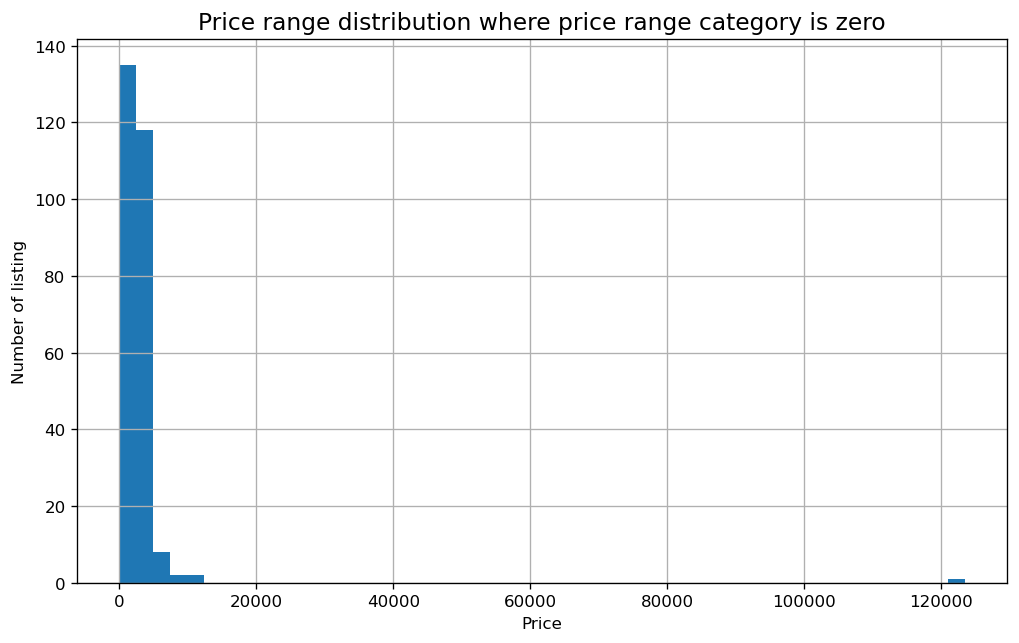

In [18]:
df[df['price_range'] == 0]['Price'].hist(bins=50)
plt.title('Price range distribution where price range category is zero', fontsize=14)
plt.xlabel("Price")
plt.ylabel('Number of listing');

In [19]:
# First, show the highest price of the ads. 
df.sort_values(by='Price', ascending=False).head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
699,VANVAN,2022-12-23 15:22:00,2022-12-23,15:22:00,"Bachelor, 1 and 2 Bedroom Apartments",https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,NaN,123456,False,0.000000,0
1980,VANVAN,2022-12-12 10:56:00,2022-12-12,10:56:00,Ultra Customized Morden Luxury House In West P...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,4,3958.0,25000,False,6.316321,4
1318,VANVAN,2022-12-20 11:11:00,2022-12-20,11:11:00,Furnished Two Bedroom Sub-Penthouse at Shangri...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,2694.0,25000,True,9.279881,4
210,VANVAN,2022-12-26 10:06:00,2022-12-26,10:06:00,Luxury Furnished 3 Bed + Den 4 Bath Condo at T...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,2223.0,24995,True,11.243815,4
436,VANVAN,2022-12-25 14:41:00,2022-12-25,14:41:00,Furnished luxury Mansion 7 bed/7 bath availabl...,https://vancouver.craigslist.org/van/apa/d/wes...,vancouver,6,10000.0,22880,True,2.288000,1


In [20]:
#I found outlier so I drop it to start. 
df.drop(df[df["Price"] == 500000].index, axis=0, inplace=True)

## Price distribution

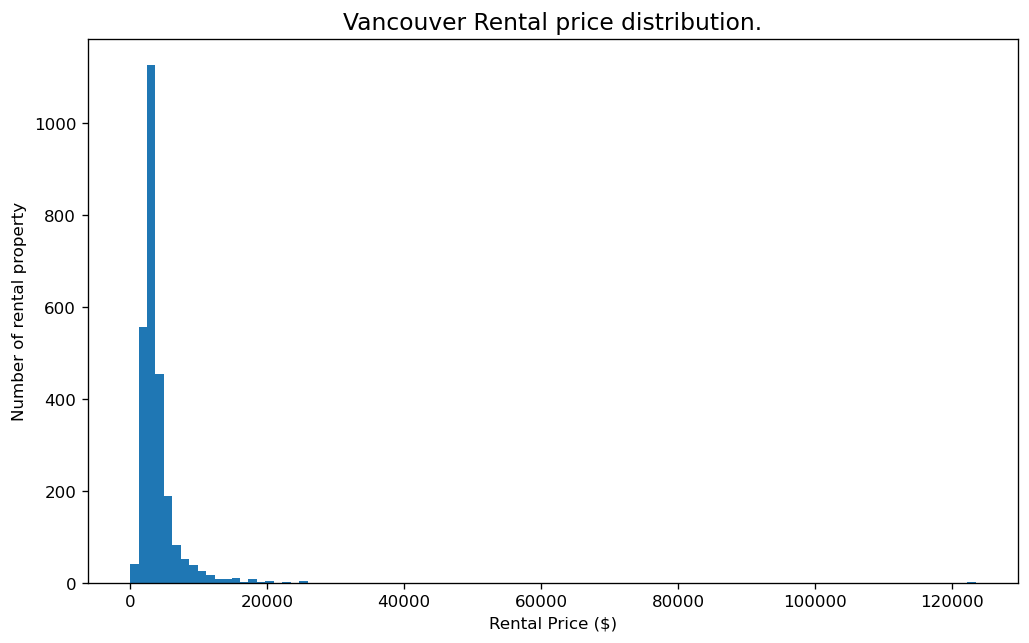

In [21]:
plt.hist(df["Price"], bins=100)
plt.title(f'{city} Rental price distribution.', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

## Relationship between Price and SQFT

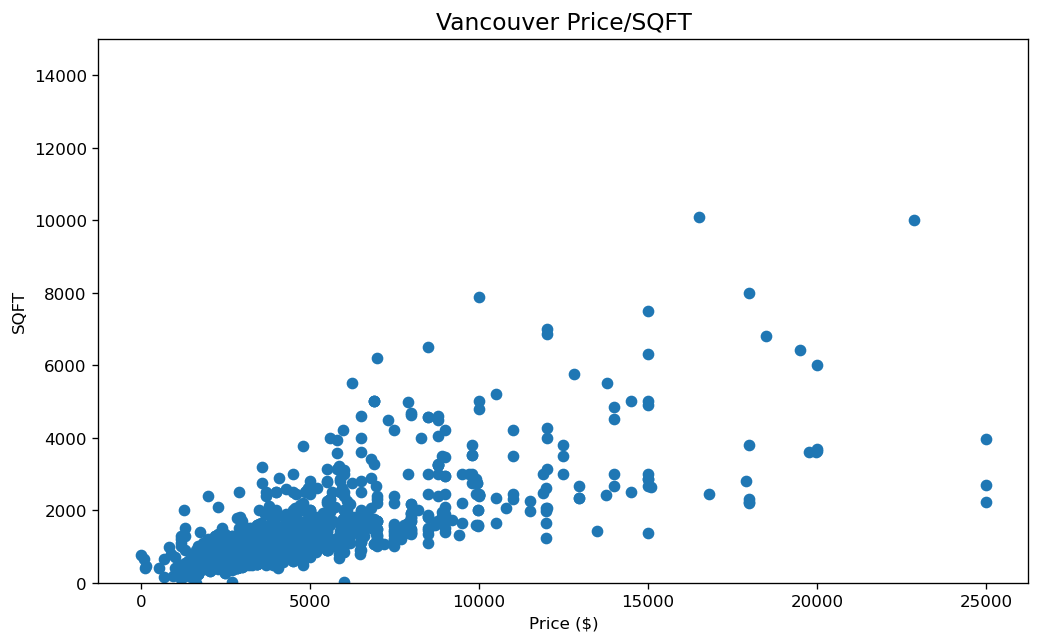

In [22]:
# Relationship between SQFT and Price
plt.scatter(x=df["Price"], y=df["SQFT"])
plt.ylim((0, 15000))
plt.title(f"{city} Price/SQFT", fontsize=14)
plt.xlabel(f"Price ($)")
plt.ylabel(f"SQFT");

In [23]:
# Drop rows if sqft is zero
p_per_sqft_df.fillna(0, inplace=True)
no_sqft_idx = p_per_sqft_df[p_per_sqft_df["Price/SQFT"] == 0].index
p_per_sqft_df.drop(no_sqft_idx, axis=0, inplace=True)

In [24]:
# Drop rows if Price/SQFT > $20
p_per_sqft_df = p_per_sqft_df[p_per_sqft_df["Price/SQFT"] < 20]

## Distribution of Per SQFT Price

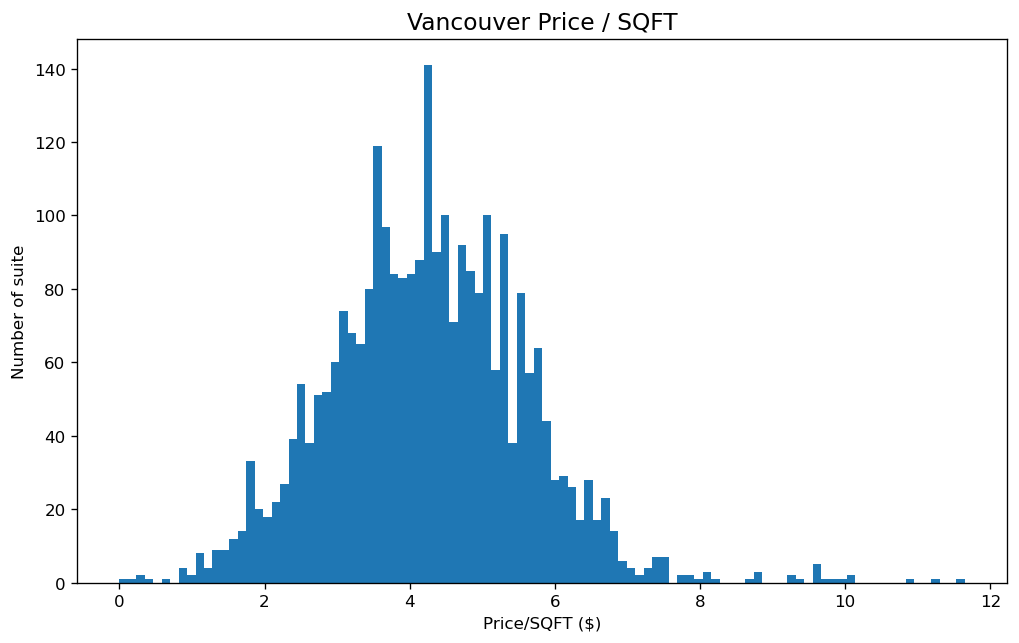

In [25]:
plt.hist(p_per_sqft_df["Price/SQFT"], bins=100)
plt.title(f"{city} Price / SQFT", fontsize=14)
plt.xlabel("Price/SQFT ($)")
plt.ylabel("Number of suite");

0
count    266.000000
mean       0.004416
std        0.037297
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.386049
Name: Price/SQFT, dtype: float64

1
count    620.000000
mean       2.620998
std        0.588013
min        0.640000
25%        2.277584
50%        2.750000
75%        3.107179
max        3.400000
Name: Price/SQFT, dtype: float64

2
count    566.000000
mean       3.794972
std        0.235078
min        3.406818
25%        3.588808
50%        3.791667
75%        4.000000
max        4.200000
Name: Price/SQFT, dtype: float64

3
count    950.000000
mean       4.886246
std        0.457869
min        4.200323
25%        4.488778
50%        4.820786
75%        5.269464
max        5.800000
Name: Price/SQFT, dtype: float64

4
count    219.000000
mean       6.661242
std        1.025331
min        5.802220
25%        6.000000
50%        6.329268
75%        6.810792
max       11.650485
Name: Price/SQFT, dtype: float64



2621

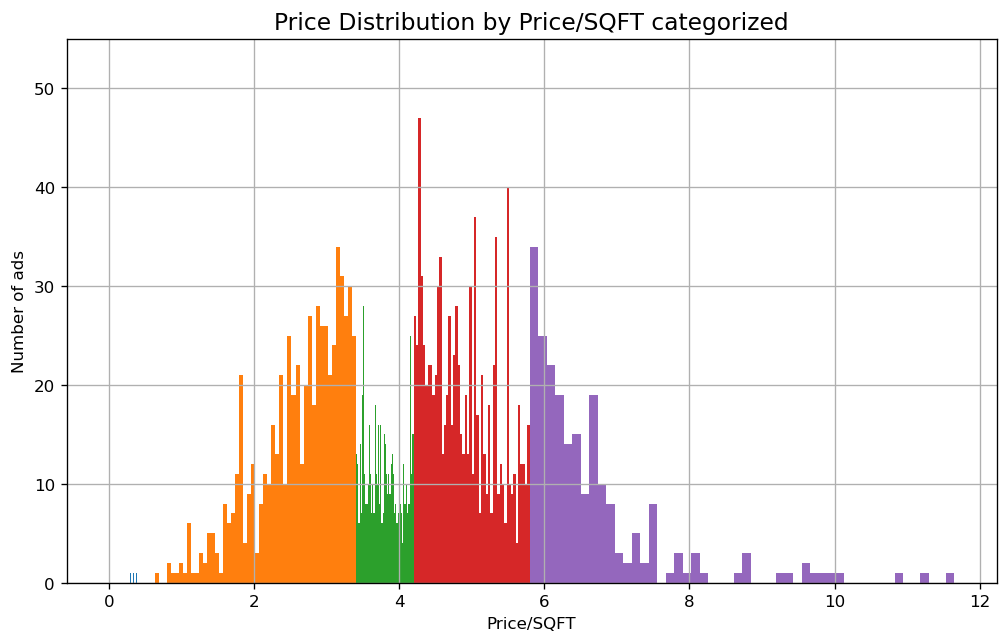

In [26]:
df_grouped = df.groupby('price_range')

number_row = 0
# Print data frame, lenth of data by category
for name, group in df_grouped:
    print(name)
    group['Price/SQFT'].hist(bins=50)
    plt.ylim(0, 55)
    plt.title("Price Distribution by Price/SQFT categorized", fontsize=14)
    plt.xlabel('Price/SQFT')
    plt.ylabel('Number of ads')
    print(group["Price/SQFT"].describe())
    number_row += len(group)
    print()
number_row

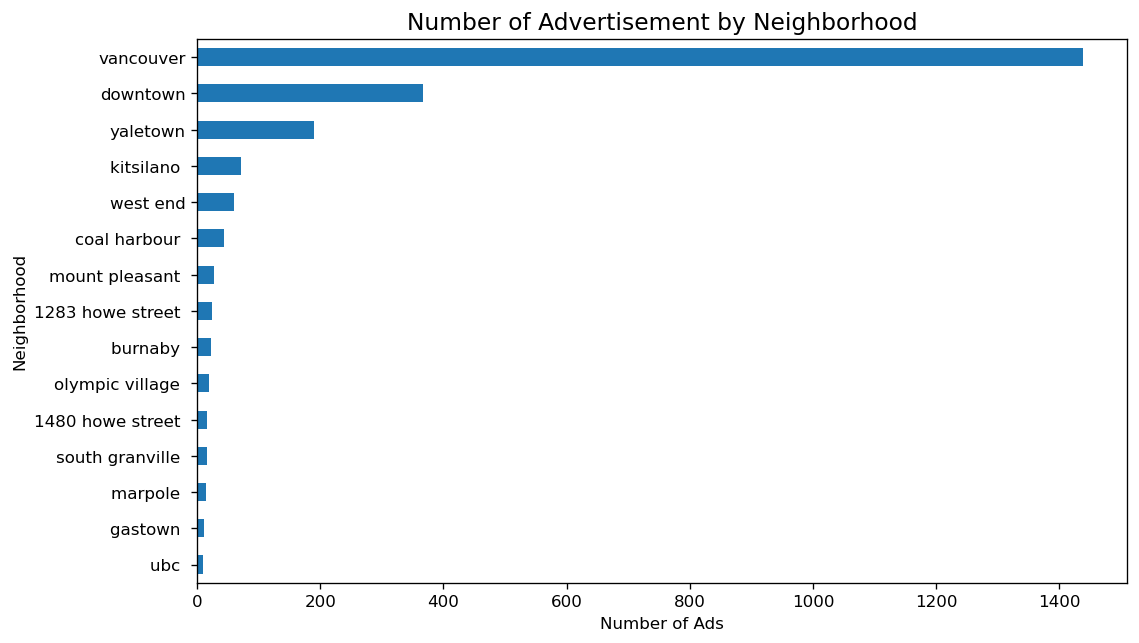

In [27]:
top_15_ads_count_by_area = p_per_sqft_df["Neighborhood"].value_counts().head(15).sort_values(ascending=True)
top_15_ads_count_by_area.plot(kind='barh')
plt.title('Number of Advertisement by Neighborhood', fontsize=14)
plt.xlabel('Number of Ads')
plt.ylabel("Neighborhood");

In [28]:
# Drop all of the neighborhood is 1. 
p_per_neighbor = p_per_sqft_df.groupby(by="Neighborhood").agg({"Price/SQFT": ['count', 'mean', 'min', 'max']})
p_per_neighbor['Price/SQFT'].sort_values(by='count', ascending=False).head(15)

,count,mean,min,max
Neighborhood,,,,
vancouver,1438,4.059836,0.153846,11.650485
downtown,366,5.056138,0.001325,10.877447
yaletown,190,4.914422,1.842308,8.097166
kitsilano,71,3.881126,1.090909,6.211111
west end,60,5.100018,3.406818,9.420796
coal harbour,43,4.378704,2.765152,6.925743
mount pleasant,28,4.370466,2.227273,5.808758
1283 howe street,24,5.657842,5.295008,6.140351
burnaby,23,3.458188,2.186047,4.672897


## Number of ads on each bedroom

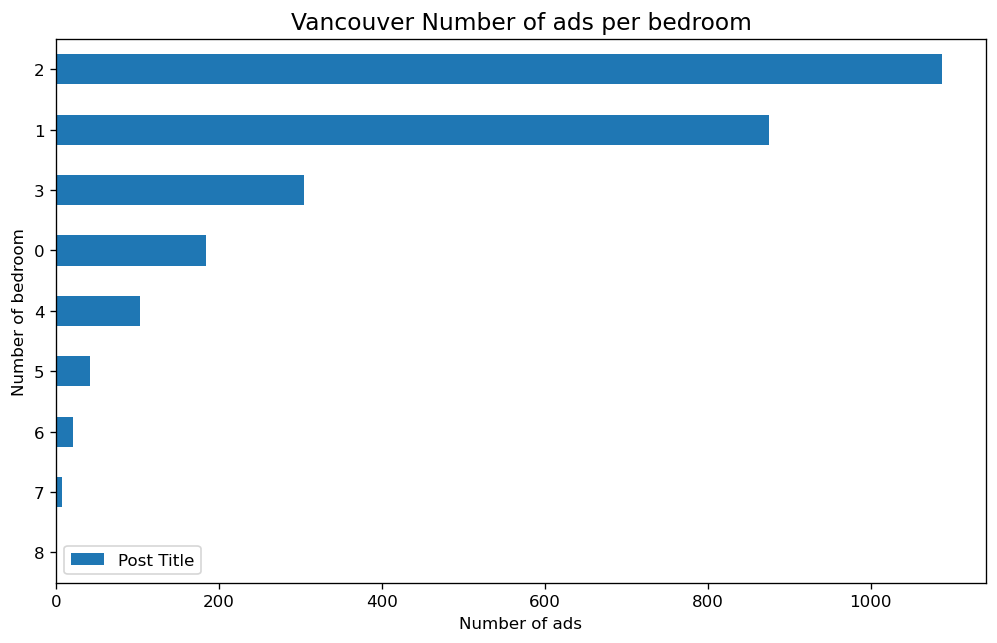

In [29]:
num_bed = df.groupby('Bedroom').agg({'Post Title': 'count'}).sort_values(by='Post Title', ascending=True)
num_bed.plot(kind='barh')
plt.title(f"{city} Number of ads per bedroom", fontsize=14)
plt.xlabel("Number of ads")
plt.ylabel("Number of bedroom");

In [30]:
# Percentage of the number of listing. 
num_bed["percent"] = num_bed / len(df) * 100
num_bed.rename(columns={'Post Title': "Number of Ads", 'percent': 'Percentage'}, inplace=True)

In [31]:
num_bed

,Number of Ads,Percentage
Bedroom,,
8,1,0.038110
7,7,0.266768
6,21,0.800305
5,42,1.600610
4,103,3.925305
0,184,7.012195
3,304,11.585366
1,875,33.346037
2,1087,41.425305


In [32]:
# Price less than $300
df[df['Price'] < 300]

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
296,VANVAN,2022-12-26 06:19:00,2022-12-26,06:19:00,scam! beware 1 bdrm in freesia building downto...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,1,755.0,1,False,0.001325,0
1157,VANVAN,2022-12-21 08:13:00,2022-12-21,08:13:00,Westsea Place - (Westend) - Studio & 1 Bedroom...,https://vancouver.craigslist.org/van/apa/d/van...,1644 nelson st.,0,NaN,0,False,0.000000,0
1551,VANVAN,2022-12-17 15:59:00,2022-12-17,15:59:00,Need help with housing,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,NaN,1,False,0.000000,0
1588,VANVAN,2022-12-16 18:53:00,2022-12-16,18:53:00,New basement suite in Riley Park Neighbourhood,https://vancouver.craigslist.org/van/apa/d/van...,riley park,1,NaN,140,False,0.000000,0
1876,VANVAN,2022-12-13 11:30:00,2022-12-13,11:30:00,DO NOT LIVE HERE - 124 DUNLEVY AVE,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,NaN,0,False,0.000000,0
1965,VANVAN,2022-12-12 13:20:00,2022-12-12,13:20:00,Vancouver Furnished Master Bedroom for Rent,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,400.0,120,True,0.300000,0
2184,VANVAN,2022-12-08 14:02:00,2022-12-08,14:02:00,DO NOT RENT 1310 WEST 10TH AVE,https://vancouver.craigslist.org/van/apa/d/van...,fairview,1,NaN,0,False,0.000000,0
2266,VANVAN,2022-12-06 21:27:00,2022-12-06,21:27:00,Sublet available Vancouver Dec 19th to Jan 2nd,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,NaN,90,False,0.000000,0
2327,VANVAN,2022-12-06 01:57:00,2022-12-06,01:57:00,No Cooking is Illegal,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,NaN,0,False,0.000000,0
2457,VANVAN,2022-12-04 15:12:00,2022-12-04,15:12:00,DT One Bedroom One Bath Furnished Dec 21-29 2022,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,650.0,100,True,0.153846,0


This post is daily rental. From this, I assume teh rental price around $100 would be daily rental suite. 

What about $1 or $0 posts?

In [33]:
# $1 ads
one_dollar = df[df["Price"] == 1]
one_dollar["Post URL"]

296     https://vancouver.craigslist.org/van/apa/d/van...
1551    https://vancouver.craigslist.org/van/apa/d/van...
Name: Post URL, dtype: object

In [34]:
# $0 ads
zero_dollar = df[df["Price"] == 0]
zero_dollar

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
1157,VANVAN,2022-12-21 08:13:00,2022-12-21,08:13:00,Westsea Place - (Westend) - Studio & 1 Bedroom...,https://vancouver.craigslist.org/van/apa/d/van...,1644 nelson st.,0,NaN,0,False,0.0,0
1876,VANVAN,2022-12-13 11:30:00,2022-12-13,11:30:00,DO NOT LIVE HERE - 124 DUNLEVY AVE,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,NaN,0,False,0.0,0
2184,VANVAN,2022-12-08 14:02:00,2022-12-08,14:02:00,DO NOT RENT 1310 WEST 10TH AVE,https://vancouver.craigslist.org/van/apa/d/van...,fairview,1,NaN,0,False,0.0,0
2327,VANVAN,2022-12-06 01:57:00,2022-12-06,01:57:00,No Cooking is Illegal,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,NaN,0,False,0.0,0


I think it most likely 0 dollar and 1 dollar ads are just not showing the price, so I will drop those rows from DataFrame. 

In [35]:
# Drop low-end outliers rows
drop_index = []
for idx in one_dollar.index:
    drop_index.append(idx)
for idx in zero_dollar.index:
    drop_index.append(idx)
print(f"Original DataFrame Size:{len(df)}\nNumber of Dropped Rows: {len(drop_index)}")
df.drop(drop_index,axis=0, inplace=True)
print(f"DataFrame size after drop rows: {len(df)}")

Original DataFrame Size:2624
Number of Dropped Rows: 6
DataFrame size after drop rows: 2618


## Analyze - 1

From the Histgram, the highest amount of rental is between 1000 to 5000. First I look what kind of market above 5000. 

I call this as 

## High-End market research


In [36]:
# top 100 higest price 
top_100_price = df[['Post Datetime', 'Neighborhood', 'Bedroom', 'SQFT', 'Price', 'IsFurnished']].sort_values(
                by="Price", ascending=False).head(100)
top_100_price.head(30)


,Post Datetime,Neighborhood,Bedroom,SQFT,Price,IsFurnished
699,2022-12-23 15:22:00,vancouver,2,NaN,123456,False
1318,2022-12-20 11:11:00,vancouver,2,2694.0,25000,True
1980,2022-12-12 10:56:00,vancouver,4,3958.0,25000,False
210,2022-12-26 10:06:00,vancouver,3,2223.0,24995,True
436,2022-12-25 14:41:00,vancouver,6,10000.0,22880,True
474,2022-12-25 10:18:00,vancouver,3,3636.0,20000,False
872,2022-12-22 15:46:00,dowtown,4,3700.0,19998,False
504,2022-12-25 09:16:00,vancouver,7,6000.0,19995,True
495,2022-12-25 09:35:00,vancouver,3,3600.0,19975,False
871,2022-12-22 15:46:00,vancouver,3,3600.0,19750,False


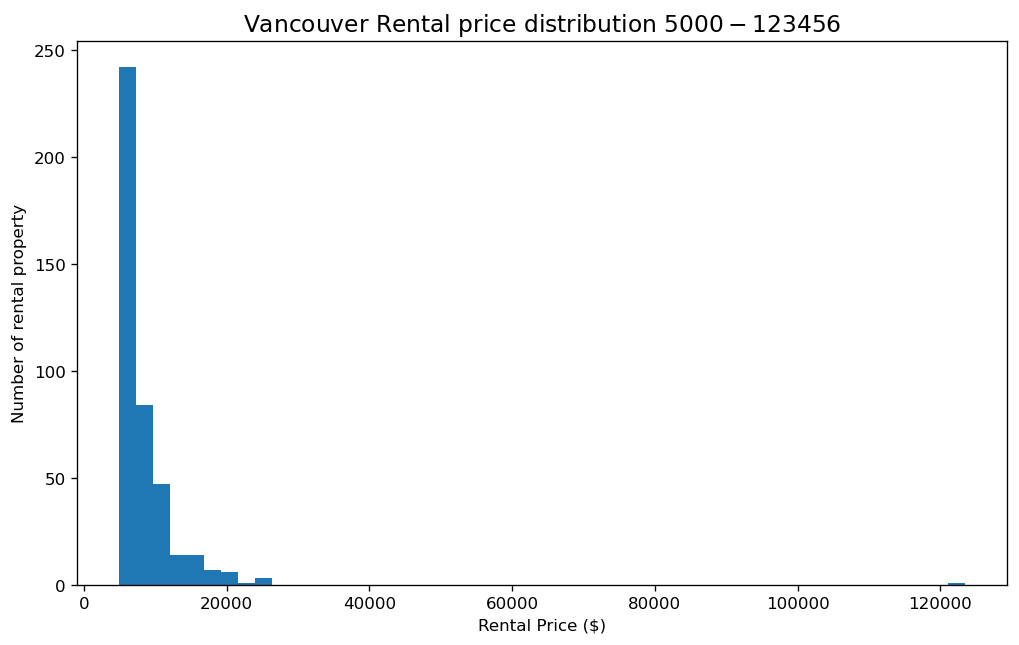

In [37]:
# What about distribution $5000 and up?
price_range = (5000, df["Price"].max())
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [38]:
# Get URL on 2 Bedroom suite in top 100. 
highest_two_bed = top_100_price[top_100_price['Bedroom'] == 2]
highest_two_bed_idx = highest_two_bed.index
for idx in highest_two_bed_idx:
    print(f'Index Number - {idx} : {df.loc[idx]["Post URL"]}')


Index Number - 699 : https://vancouver.craigslist.org/van/apa/d/vancouver-bachelor-and-bedroom/7571409378.html
Index Number - 1318 : https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-two-bedroom-sub/7568419814.html
Index Number - 2222 : https://vancouver.craigslist.org/van/apa/d/vancouver-vancouver-downtown-fairmont/7554964282.html
Index Number - 2555 : https://vancouver.craigslist.org/van/apa/d/rare-harbour-green-one-ft-stunning/7563703745.html
Index Number - 441 : https://vancouver.craigslist.org/van/apa/d/vancouver-fairmont-loft-bedroom/7571765246.html
Index Number - 1294 : https://vancouver.craigslist.org/van/apa/d/vancouver-uniqueaccommodationscom/7567894912.html
Index Number - 1054 : https://vancouver.craigslist.org/van/apa/d/vancouver-breathtaking-views-2500-sq-ft/7570816160.html
Index Number - 1244 : https://vancouver.craigslist.org/van/apa/d/vancouver-super-luxury-07-fairmont-bed/7565383014.html
Index Number - 894 : https://vancouver.craigslist.org/van/apa/d/vanco

#### What is 0.85% RULE?

This is the rough calculation to find out the purchase price to give 5 - 8% cash flow from your rental revenue with today's motgagerate. It's not accurate number but great place to start evaluating the home price for your investment. 

In [39]:
# Average Price on those pent house
avg_rent = np.average(highest_two_bed["Price"][1:].to_numpy())
max_rent = np.max(highest_two_bed["Price"][1:].to_numpy())
# 0.85% RULE
avg_house_p = np.round(avg_rent / (0.85/100), 2)
max_house_p = np.round(max_rent / (0.85/100), 2)
print(f"Price between ${avg_house_p*0.8} - ${max_house_p}")

Price between $1191611.256 - $2941176.47


In [40]:
# Rental price higher than $5000.
more_than_5000 = df[df["Price"] > 5000]
more_than_5000.groupby(by=["Bedroom", "IsFurnished"]).agg({'SQFT': ["min", "max"],
                                                         "Price": ['min', 'max', 'count']})

SQFT           Price              
                        min      max    min     max count
Bedroom IsFurnished                                      
0       True         1357.0   1357.0   8000    8000     1
1       False        2000.0   2000.0   6500    6500     1
        True          900.0   1855.0   5500    8500     3
2       False         675.0   2936.0   5190  123456    89
        True          800.0   2873.0   5100   25000    68
3       False          14.0   4000.0   5100   20000    80
        True         1000.0   4000.0   5200   24995    33
4       False        1312.0   6300.0   5200   25000    38
        True         1400.0   6800.0   5500   18500    20
5       False        1500.0   6850.0   5200   19500    26
        True         2250.0   6500.0   6088   14995     9
6       False        2300.0  10098.0   5600   18000    12
        True         3000.0  29789.0   5600   22880     7
7       False        2900.0   4800.0   6500    9995     5
        True         6000.0   6000.0  19995   19995     1
8       False        4980.0   4980.0   7900    7900     1

In [41]:
# top 10 most expensive rental in Vancouver
top_10 = top_100_price.head(10)
top_10

,Post Datetime,Neighborhood,Bedroom,SQFT,Price,IsFurnished
699,2022-12-23 15:22:00,vancouver,2,NaN,123456,False
1318,2022-12-20 11:11:00,vancouver,2,2694.0,25000,True
1980,2022-12-12 10:56:00,vancouver,4,3958.0,25000,False
210,2022-12-26 10:06:00,vancouver,3,2223.0,24995,True
436,2022-12-25 14:41:00,vancouver,6,10000.0,22880,True
474,2022-12-25 10:18:00,vancouver,3,3636.0,20000,False
872,2022-12-22 15:46:00,dowtown,4,3700.0,19998,False
504,2022-12-25 09:16:00,vancouver,7,6000.0,19995,True
495,2022-12-25 09:35:00,vancouver,3,3600.0,19975,False
871,2022-12-22 15:46:00,vancouver,3,3600.0,19750,False


In [42]:
# Then get the URL on those top 10 most expensive rental in Vancouver. 
top_10_idx = top_10.index
for idx in top_10_idx:
    print(f'Index Number - {idx}/Number of Bedroom - {df.loc[idx]["Bedroom"]}/SQFT - {df.loc[idx]["SQFT"]}/Location - {df.loc[idx]["Neighborhood"]}\n{df.loc[idx]["Post URL"]}')

Index Number - 699/Number of Bedroom - 2/SQFT - nan/Location - vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-bachelor-and-bedroom/7571409378.html
Index Number - 1318/Number of Bedroom - 2/SQFT - 2694.0/Location - vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-two-bedroom-sub/7568419814.html
Index Number - 1980/Number of Bedroom - 4/SQFT - 3958.0/Location - vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-ultra-customized-morden/7567534610.html
Index Number - 210/Number of Bedroom - 3/SQFT - 2223.0/Location - vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-luxury-furnished-bed-den-bath/7568077632.html
Index Number - 436/Number of Bedroom - 6/SQFT - 10000.0/Location - vancouver
https://vancouver.craigslist.org/van/apa/d/west-vancouver-furnished-luxury-mansion/7562366149.html
Index Number - 474/Number of Bedroom - 3/SQFT - 3636.0/Location - vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-coal-harbour-lu

From above data, Downtown Vanvouver rental market is different world. I must make decision to define what is the outlier of high-end rental. 

If the number of the high-end prices are large enough, I can make DataFrame for only high-end and search for the high-end market opportunities. 

Clearly, I should not mix with regular market and high-end market because it will provide me biased price average to determin the valuse of the house. 

I am wondering that <a href='https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/Table?TableId=2.1.31.3&GeographyId=2410&GeographyTypeId=3&DisplayAs=Table&GeograghyName=Vancouver'>CMHC Vancouver rental market report</a> concerns about those outliers. 

## Analyze - 2 


## Analyze under 5000, and i call them for regular market. 
* What is the percentage of the Furnished rental suite? 
* Is there any price different? 
* How many bedroom suite has most on ads? And is it any different in area?
* How much is the rental price in general? 


Tne price around $100 is most likely daily rental so I will store in different variable so I might be able to do something with them. 

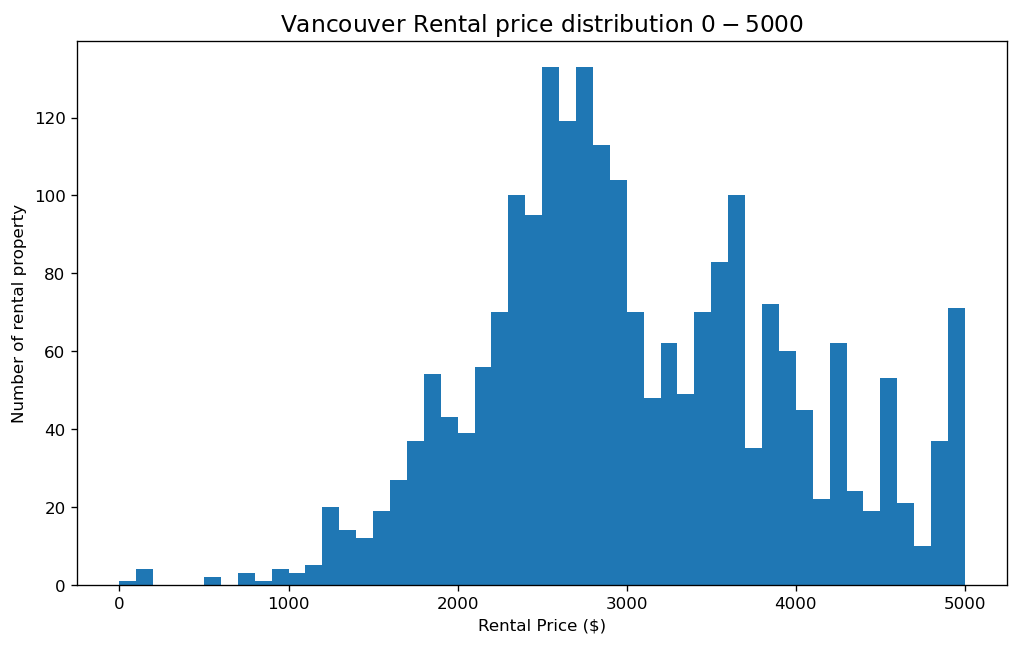

In [43]:
# What about distribution $0 - $5000?
price_range = (0, 5000)
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [44]:
day_rental = df[df["Price"].between(10, 300)]
day_rental

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
1588,VANVAN,2022-12-16 18:53:00,2022-12-16,18:53:00,New basement suite in Riley Park Neighbourhood,https://vancouver.craigslist.org/van/apa/d/van...,riley park,1,NaN,140,False,0.000000,0
1965,VANVAN,2022-12-12 13:20:00,2022-12-12,13:20:00,Vancouver Furnished Master Bedroom for Rent,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,400.0,120,True,0.300000,0
2266,VANVAN,2022-12-06 21:27:00,2022-12-06,21:27:00,Sublet available Vancouver Dec 19th to Jan 2nd,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,NaN,90,False,0.000000,0
2457,VANVAN,2022-12-04 15:12:00,2022-12-04,15:12:00,DT One Bedroom One Bath Furnished Dec 21-29 2022,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,650.0,100,True,0.153846,0
2603,VANVAN,2022-11-30 20:47:00,2022-11-30,20:47:00,1 Bedroom suite furnished,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,450.0,150,True,0.333333,0


In [45]:
# Drop the rental price over $5000. 
under_5000 = df.drop(more_than_5000.index, axis=0)
print(f'Drop {len(more_than_5000)} rows and data contains {len(under_5000)} rows of data.')

Drop 394 rows and data contains 2224 rows of data.


In [46]:
# then also drop daily rentals
under_5000 = under_5000.drop(day_rental.index, axis=0)
print(f'Drop {len(day_rental)} rows and data contains {len(under_5000)} rows of data.')

Drop 5 rows and data contains 2219 rows of data.


In [47]:
# What is the top 10 highest price on under $5000. Is it no outlier?
under_5000.sort_values(by="Price", ascending=False).head(10)

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
1779,VANVAN,2022-12-14 14:00:00,2022-12-14,14:00:00,SPACIOUS WATERFRONT 2BED APARTMENT IN COAL HAR...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,1300.0,5000,False,3.846154,2
372,VANVAN,2022-12-25 20:00:00,2022-12-25,20:00:00,FRASER AND 41ST VANCOUVER EAST HOUSE 3 BED 2 BATH,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,2000.0,5000,False,2.500000,1
1609,VANVAN,2022-12-16 17:36:00,2022-12-16,17:36:00,A/C Pet friendly Apartment at Cambie Gardens 7...,https://vancouver.craigslist.org/van/apa/d/van...,oakridge,2,1155.0,5000,False,4.329004,3
1951,VANVAN,2022-12-12 16:27:00,2022-12-12,16:27:00,UBC furnished ocean view 2 bedroom for rent,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,NaN,5000,True,0.000000,0
2356,VANVAN,2022-12-05 20:03:00,2022-12-05,20:03:00,3 Bedroom + Den Sub-Penthouse at 8X On the Par...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,3,1200.0,5000,False,4.166667,2
932,VANVAN,2022-12-22 11:32:00,2022-12-22,11:32:00,Spacious 3 Bedroom + Den Available for Lease,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,1200.0,5000,False,4.166667,2
1506,VANVAN,2022-12-18 16:28:00,2022-12-18,16:28:00,Luxury modern new furnished Vancouver Suite,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,950.0,5000,True,5.263158,3
2448,VANVAN,2022-12-04 17:53:00,2022-12-04,17:53:00,2BD 2BATH Fully furnished | Iconic Wall Centr...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,2,1067.0,5000,True,4.686036,3
1221,VANVAN,2022-12-20 15:48:00,2022-12-20,15:48:00,2 BED + DEN W/ VIEWS FOR RENT @ CIELO!!,https://vancouver.craigslist.org/van/apa/d/van...,coal harbour,2,1277.0,5000,False,3.915427,2
1969,VANVAN,2022-12-12 12:24:00,2022-12-12,12:24:00,Yaletown fully furnished 3 bedroom sub-penthou...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,1980.0,5000,True,2.525253,1


In [48]:
# How many rentals are $5000?
under_5000[under_5000["Price"] == 5000] 

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
141,VANVAN,2022-12-26 11:07:00,2022-12-26,11:07:00,Spacious 3BED/2BATH @ 8X On the Park,https://vancouver.craigslist.org/van/apa/d/van...,yaletown,3,1200.0,5000,False,4.166667,2
372,VANVAN,2022-12-25 20:00:00,2022-12-25,20:00:00,FRASER AND 41ST VANCOUVER EAST HOUSE 3 BED 2 BATH,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,2000.0,5000,False,2.500000,1
778,VANVAN,2022-12-23 09:22:00,2022-12-23,09:22:00,5 star luxury Shangri-La hotel condo(furnished...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,1045.0,5000,False,4.784689,3
805,VANVAN,2022-12-22 23:12:00,2022-12-22,23:12:00,"Eco Penthouse Loft, with Private Roof Deck",https://vancouver.craigslist.org/van/apa/d/van...,west side - kitsilano,2,900.0,5000,False,5.555556,3
883,VANVAN,2022-12-22 14:37:00,2022-12-22,14:37:00,(UniqueAccommodations.com) ID:5184 Kitsilano 2...,https://vancouver.craigslist.org/van/apa/d/van...,kitsilano,2,1100.0,5000,False,4.545455,3
932,VANVAN,2022-12-22 11:32:00,2022-12-22,11:32:00,Spacious 3 Bedroom + Den Available for Lease,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,1200.0,5000,False,4.166667,2
1221,VANVAN,2022-12-20 15:48:00,2022-12-20,15:48:00,2 BED + DEN W/ VIEWS FOR RENT @ CIELO!!,https://vancouver.craigslist.org/van/apa/d/van...,coal harbour,2,1277.0,5000,False,3.915427,2
1282,VANVAN,2022-12-20 12:27:00,2022-12-20,12:27:00,(UniqueAccommodations.com) ID:4949 4 BED rare ...,https://vancouver.craigslist.org/van/apa/d/van...,cambie,4,1839.0,5000,False,2.718869,1
1404,VANVAN,2022-12-19 14:14:00,2022-12-19,14:14:00,"--(OBsold.com)-- Stunning Furnished 1bd+den, m...",https://vancouver.craigslist.org/van/apa/d/nor...,lower lonsdale,1,733.0,5000,True,6.821282,4
1506,VANVAN,2022-12-18 16:28:00,2022-12-18,16:28:00,Luxury modern new furnished Vancouver Suite,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,950.0,5000,True,5.263158,3


In [49]:
# What is the cheapest rent?
under_5000.sort_values(by="Price").head(20)

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
2009,VANVAN,2022-12-11 21:39:00,2022-12-11,21:39:00,Double Car Garage for rent !!,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,400.0,550,False,1.375000,1
1520,VANVAN,2022-12-18 12:44:00,2022-12-18,12:44:00,Rooms in SRO building from $595,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,NaN,595,False,0.000000,0
2507,VANVAN,2022-12-03 08:11:00,2022-12-03,08:11:00,1 bedroom available for rent in a shared suite,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,650.0,700,False,1.076923,1
20,VANVAN,2022-12-26 17:30:00,2022-12-26,17:30:00,Microsuite Available Now,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,150.0,700,False,4.666667,3
1278,VANVAN,2022-12-20 12:44:00,2022-12-20,12:44:00,Nice and cozy room available (H65) (Surrey),https://vancouver.craigslist.org/van/apa/d/sur...,surrey,1,NaN,700,False,0.000000,0
1031,VANVAN,2022-12-21 19:40:00,2022-12-21,19:40:00,Room for rent $830/month! utilities & internet...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,997.0,830,False,0.832497,1
1649,VANVAN,2022-12-16 11:50:00,2022-12-16,11:50:00,student accommodation,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,800.0,900,False,1.125000,1
780,VANVAN,2022-12-23 08:39:00,2022-12-23,08:39:00,One in Kits on West Broadway 10 mins from UBC...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,6,NaN,950,False,0.000000,0
906,VANVAN,2022-12-22 13:14:00,2022-12-22,13:14:00,Micro-Mini suite(Ground Level 5th and Nanaimo/...,https://vancouver.craigslist.org/van/apa/d/mic...,vancouver,0,191.0,950,False,4.973822,3
1159,VANVAN,2022-12-21 07:49:00,2022-12-21,07:49:00,Homestay bedrooms,https://vancouver.craigslist.org/van/apa/d/van...,westwood plateau coquitlam,2,NaN,990,False,0.000000,0


In [50]:
# Count how many rentals are furnished 
num_furnished_suite = df[df['IsFurnished'] == True]["IsFurnished"].count()
num_unfurnished_suite = len(df) - num_furnished_suite
furnished_suite_percent = np.round((num_furnished_suite / len(df)) * 100, 2)
print(f"Number of furnished suite is {num_furnished_suite}, and it's {furnished_suite_percent}% of the entire list.")

Number of furnished suite is 651, and it's 24.87% of the entire list.


In [51]:
# Find out the number of ads on each bedrooms number.  
num_bed = np.sort(df["Bedroom"].unique())
suite_counts = []
for i in range(len(num_bed)):
    suite_count = len(df[df['Bedroom'] == num_bed[i]])
    suite_counts.append(suite_count)
    #print(f'Number of {num_bed[i]} Bedroom suite: {len(df[df["Bedroom"] == num_bed[i]])}')
#print(f"List of suite counts: {suite_counts}")

In [52]:
# Find out Mean, Max, Min of SQFT and Price of each bedroom and SUM of furnished suite and total suite on each bedroom. 
df_count = df.groupby(by=['Bedroom']).agg({'SQFT': ['mean', 'max', 'min'],
                                                 'Price': ['mean', 'max', 'min'],
                                                  'IsFurnished': ['sum', 'count']})
df_count['percent furnished'] = df_count['IsFurnished']['sum'] / df_count["IsFurnished"]['count']
df_count

SQFT                         Price               IsFurnished  \
                mean      max     min         mean     max   min         sum   
Bedroom                                                                        
0         438.459627   1357.0   103.0  2323.160221    8000   550          54   
1         620.627273   2400.0     1.0  2576.502294    8500    90         252   
2         985.453441   2936.0     7.0  4092.809568  123456   990         248   
3        1534.352113   4000.0    14.0  5522.907895   24995  1000          58   
4        2568.734043   6800.0   900.0  6773.135922   25000  2300          22   
5        3839.666667   6850.0  1500.0  8696.595238   19500  1300           9   
6        6745.473684  29789.0  2300.0  9922.619048   22880   950           7   
7        4028.333333   6000.0  1300.0  8798.571429   19995  1300           1   
8        4980.000000   4980.0  4980.0  7900.000000    7900  7900           0   

              percent furnished  
        count                    
Bedroom                          
0         181          0.298343  
1         872          0.288991  
2        1087          0.228151  
3         304          0.190789  
4         103          0.213592  
5          42          0.214286  
6          21          0.333333  
7           7          0.142857  
8           1          0.000000

In [53]:
# Price per furnished suit on each bedroom
#df_price_furnished = df.drop(['Post Datetime', 'Post Title', 'Post URL', 'Neighborhood'], axis=1)
df_price_furnished = df.groupby(['Bedroom', 'IsFurnished']).agg({'Price': ['mean', 'max', 'min', 'count'],
                                                               "SQFT": ['mean', 'max', 'min']})
df_price_furnished

Price                               SQFT           \
                             mean     max    min count          mean      max   
Bedroom IsFurnished                                                             
0       False         2237.023622    4050    550   127    435.292035   1200.0   
        True          2525.740741    8000   1590    54    445.916667   1357.0   
1       False         2434.303226    6500     90   620    623.741636   2400.0   
        True          2926.357143    8500    100   252    613.405172   1855.0   
2       False         3907.325387  123456    990   839    972.199735   2936.0   
        True          4720.314516   25000   1800   248   1028.642241   2873.0   
3       False         5166.886179   20000   1000   246   1509.555066   4000.0   
        True          7032.931034   24995   2250    58   1633.105263   4000.0   
4       False         6245.098765   25000   2300    81   2528.123288   6300.0   
        True          8717.272727   18500   4800    22   2709.904762   6800.0   
5       False         8502.545455   19500   1300    33   3887.500000   6850.0   
        True          9408.111111   14995   6088     9   3680.222222   6500.0   
6       False         8957.142857   18000    950    14   5233.538462  10098.0   
        True         11853.571429   22880   5600     7  10021.333333  29789.0   
7       False         6932.500000    9995   1300     6   3634.000000   4800.0   
        True         19995.000000   19995  19995     1   6000.000000   6000.0   
8       False         7900.000000    7900   7900     1   4980.000000   4980.0   

                             
                        min  
Bedroom IsFurnished          
0       False         103.0  
        True          180.0  
1       False           1.0  
        True          361.0  
2       False           7.0  
        True          500.0  
3       False          14.0  
        True          781.0  
4       False         900.0  
        True         1400.0  
5       False        1500.0  
        True         2250.0  
6       False        2300.0  
        True         3000.0  
7       False        1300.0  
        True         6000.0  
8       False        4980.0

Dropped extrimely low price add, and it seems no outlier on the price

In [54]:
# Count how many ads per day.1=Mon, 2=Tue, ......, 7=Sun
df["Weekday"] = df["Post Datetime"].dt.isocalendar().day
num_ad_per_day_df = df.groupby('Post Date').agg({'Post Title': 'count',
                                                "Weekday": 'first'})

num_ad_per_day_df

,Post Title,Weekday
Post Date,,
2022-11-30,25,3
2022-12-01,47,4
2022-12-02,42,5
2022-12-03,38,6
2022-12-04,41,7
2022-12-05,100,1
2022-12-06,68,2
2022-12-07,54,3
2022-12-08,60,4


Which day of the week have more ads? 

Is there any day of the week that having more ads than others? 

## Share

#### Data Visualization:
The most important thing is what information do I want to tell. 

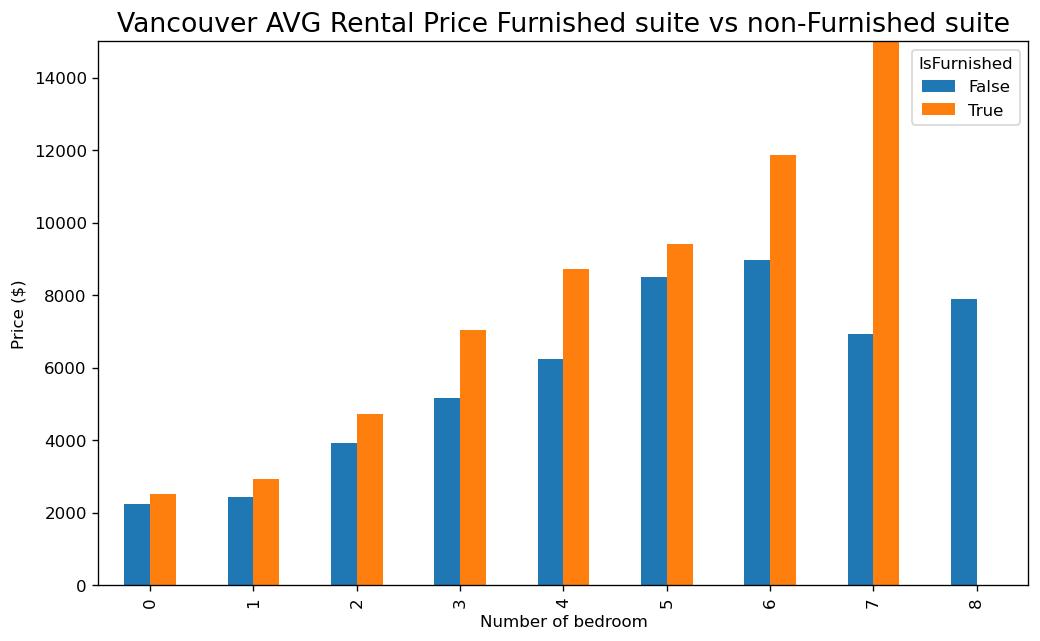

In [55]:
df_price_furnished["Price"]["mean"].unstack().plot(kind='bar')
plt.title(f'{city} AVG Rental Price Furnished suite vs non-Furnished suite', fontsize=16)
plt.xlabel('Number of bedroom')
plt.ylabel('Price ($)')
plt.ylim((0, 15000));

In [56]:
titles = []
for title in df["Post Title"][:5]:
    titles.append(title)
titles

['Available February 1st -NEW BUILDING-Pet Friendly 2 BR@ 1168 Pendrell',
 'NEW BUILDING-Pet Friendly 2 BR@ 1168 Pendrell-Available February 1st',
 'Pet Friendly studio with storage and patio in Mount Pleasant',
 'One Bedroom in Kitsilano',
 '2 elevators, Quartz countertops, Outdoor patio and BBQ area']

In [57]:
df[['Post Datetime', 'Post Title', "Price", "Bedroom", "IsFurnished"]][:10]

,Post Datetime,Post Title,Price,Bedroom,IsFurnished
0,2022-12-26 17:57:00,Available February 1st -NEW BUILDING-Pet Frien...,3700,2,False
1,2022-12-26 17:56:00,NEW BUILDING-Pet Friendly 2 BR@ 1168 Pendrell-...,3700,2,False
2,2022-12-26 17:56:00,Pet Friendly studio with storage and patio in ...,2355,0,False
3,2022-12-26 17:56:00,One Bedroom in Kitsilano,1875,1,False
4,2022-12-26 17:53:00,"2 elevators, Quartz countertops, Outdoor patio...",2795,1,False
5,2022-12-26 17:53:00,NEW BUILDING-Available February 1st-Pet Friend...,3700,2,False
6,2022-12-26 17:51:00,2 Bedrooms + Den Apartment in Fairview/South G...,2750,2,False
7,2022-12-26 17:51:00,Six Year Old House ( One Bedroom Room--Basement),1500,1,False
8,2022-12-26 17:43:00,2 Bed Apartment for Rent Next to Seawall,2600,2,False
9,2022-12-26 17:35:00,Available January 27th -Pet Welcome Furnished ...,3490,2,True


In [58]:
np.mean(df["Price/SQFT"])

4.713207516620958

## Act